<a href="https://colab.research.google.com/github/Patrick5455/Change-Point-Analysis-of-Covid19-Bayesian-Inference-SIR-SEIR-Modelling/blob/master/dependencies/covid19_inference-master/scripts/interactive/example_one_bundesland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change point analysis to quantify the impact of the Ghanian government policy interventions to slow the spread of COVID-19

>> For easier navigation, open with google-colab link below and use the Table of contents in the left pane


`Mount Google Drive to save files and visuals`

In [ ]:
#To mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')#To Save the trace results to a pickle file

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


`install the library to be used for this analysis`

check [here](https://science.sciencemag.org/content/sci/369/6500/eabb9789.full.pdf) for more info on the research work for this library

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-am0k_z_1
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-am0k_z_1
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=236e0b9b6b637843d7b94361e7b3d3b80c1b603df4484a72d19dc4d4c9cebceb
  Stored in directory: /tmp/pip-ephem-wheel-cache-j290vkwq/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference




1.   List item
2.   List item



# Bayesian Inference of Ghana Covid 19 Data
Non-hierarchical model using jhu data.

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [ ]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import pickle

In [ ]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

### Define Utility Function

####save model trace


In [ ]:
def save_load_modelTrace (action, modelTrace, modelTrace_name='new_model.pickle'):

  if action == "wb":
    pickle_out = open('/content/models/'+modelTrace_name,action)
    pickle.dump(modelTrace, pickle_out)
    pickle_out.close() 

  elif action=="rb":
    pickle_in = open('/content/models/'+modelTrace_name,action)
    modelTrace=pickle.load(pickle_in)
    
    return modelTrace

#### Plot timeseries

In [ ]:
def plot_timeseries(model, model_trace, start=None, end=None,
                    file_name="new_timeseries.png", offset=3000,
                    add_more_later=False
                    ):
  fig, axes = cov19.plot.timeseries_overview(model, model_trace,annotate_watermark=True,
                                             
                                             save_to="/content/visuals"+file_name, forecast_label='Ghana Forecast',

                                             forecast_heading="Ghana Covid19 Forecast",

                                             add_more_later=add_more_later,
                                             
                                     offset=offset, start=datetime.datetime(start), end=datetime.datetime(end))
  return fig

#### Plot simple timeseries

In [ ]:
def plot_simpleTimeSeries(data,type_of_plot = 'data'):

  """
   low-level function to plot anything that has a date on the x-axis.

        Parameters
        ----------
        x : array of datetime.datetime
            times for the x axis

        y : array, 1d or 2d
            data to plot. if 2d, we plot the CI as fill_between (if CI enabled in rc
            params)
            if 2d, then first dim is realization and second dim is time matching `x`
            if 1d then first tim is time matching `x`

         what: str, optional
            what type of data is provided in x. sets the style used for plotting:
            * `data` for data points
            * `fcast` for model forecast (prediction)
            * `model` for model reproduction of data (past)

  """

  date=data.index
  figures=data
  fig, axes = cov19._timeseries(x=date, y=figures, what=type_of_plot)
  return fig

#### Plot Posterior Parameters

In [ ]:
def plot_distributions(model, model_trace, color=None):
    fig, axes = plt.subplots(6, 3, figsize=(12, 6))
    #axes[0, 2].set_visible(False)
    #axes[1, 2].set_visible(False)
    left_column = ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
    mid_column = ["offset_modulation","sigma_obs","I_begin","transient_day_1","transient_day_2","transient_day_3"]
    right_column =  ["delay", "transient_len_1", "transient_len_2", "transient_len_3"]

    for idx, var in enumerate(left_column):
        cov19.plot._distribution(model, trace, var, ax=axes[idx, 0], color=color)

    for idx, var in enumerate(mid_column):
        cov19.plot._distribution(model, trace, var, ax=axes[idx, 1], color=color)

    for idx, var in enumerate(right_column):
        cov19.plot._distribution(model, trace, var, ax=axes[idx+2, 2], color=color)

    fig.tight_layout()
    return fig

#### Define Model

In [231]:
 def create_model(model_params, bd, ed, sim_begin, sim_end, change_points):
   with cov19.model.Cov19Model(params_model=model_params) as this_model:

      """
      params_model is used to initlaise an object instance of Cov19Model

          change_points is a list of dates used to specify the change points for our model

          model_type could be SIR or SIER
      """



    #specify extra attriubutes
      data_end=ed,
      sim_begin=sim_begin   #datetime.datetime(2020,3,4),
      sim_end=sim_end       #datetime.datetime(2020,8,4),

      # Create the an array of the time dependent infection rate lambda
      lambda_t_log = cov19.model.lambda_t_with_sigmoids(
          pr_median_lambda_0=0.4,
          pr_sigma_lambda_0=0.5,
          change_points_list=change_points,  # The change point priors we constructed earlier
          name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
      )

      # set prior distribution for the recovery rate
      mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

      # This builds a decorrelated prior for I_begin for faster inference.
      # It is not necessary to use it, one can simply remove it and use the default argument
      # for pr_I_begin in cov19.SIR
      prior_I = cov19.model.uncorrelated_prior_I(
          lambda_t_log=lambda_t_log,
          mu=mu,
          pr_median_delay=pr_delay,
          name_I_begin="I_begin",
          name_I_begin_ratio_log="I_begin_ratio_log",
          pr_sigma_I_begin=2,
          n_data_points_used=5,
      )

      # Use lambda_t_log and mu to run the SIR model
      new_cases = cov19.model.SIR(
          lambda_t_log=lambda_t_log,
          mu=mu,
          name_new_I_t="new_I_t",
          name_I_t="I_t",
          name_I_begin="I_begin",
          pr_I_begin=prior_I,
      )

      # Delay the cases by a lognormal reporting delay
      new_cases = cov19.model.delay_cases(
          cases=new_cases,
          name_cases="delayed_cases",
          name_delay="delay",
          name_width="delay-width",
          pr_mean_of_median=pr_delay,
          pr_sigma_of_median=0.2,
          pr_median_of_width=0.3,
      )

      # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
      # Also adds the "new_cases" variable to the trace that has all model features.
      new_cases = cov19.model.week_modulation(
          cases=new_cases,
          name_cases="new_cases",
          name_weekend_factor="weekend_factor",
          name_offset_modulation="offset_modulation",
          week_modulation_type="abs_sine",
          pr_mean_weekend_factor=0.3,
          pr_sigma_weekend_factor=0.5,
          weekend_days=(6, 7),
      )

      # Define the likelihood, uses the new_cases_obs set as model parameter
      cov19.model.student_t_likelihood(new_cases)


## Data retrieval 

> Task a -c

- Download the COVID19 case data for your assigned country

- Pre-process the downloaded data such that the starting date of the data is when the number of covid19 cases in your country reaches 100 and dominated by a community transmission.

- It is unlikely but, if there are dates that have NaN values, perform linear regression to fill these missing values. Make sure the final data has a continuous date - ensure no date is missing. Zero number of cases for a given date is ok.



> Use John Hopkins Database

In [ ]:
jhu = cov19.data_retrieval.JHU()  # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


### Get total confirmed case for Ghana and its new cases
> Ghana recorded its first covid case on 14th of March


In [ ]:
bd = datetime.datetime(2020, 3, 14)  # first covid case
ed = datetime.datetime.now() # data ends today

In [ ]:
total_cases_obs = jhu.get_total(
    value="confirmed", country="Ghana", data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    value="confirmed", country="Ghana", data_begin=bd, data_end=ed
)

In [ ]:
total_cases_obs

date
2020-03-14        3
2020-03-15        6
2020-03-16        6
2020-03-17        7
2020-03-18        7
              ...  
2020-08-04    37812
2020-08-05    39075
2020-08-06    39642
2020-08-07    40097
2020-08-08    40533
Name: confirmed, Length: 148, dtype: int64

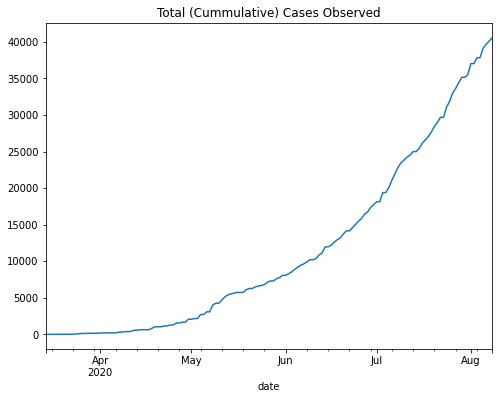

In [ ]:
total_cases_obs.plot(figsize=(8,6))
plt.title('Total (Cummulative) Cases Observed')
plt.savefig(fname='/content/visuals/totalCases_cumm.png', format='png')

In [ ]:
new_cases_obs

date
2020-03-14       3
2020-03-15       3
2020-03-16       0
2020-03-17       1
2020-03-18       0
              ... 
2020-08-04       0
2020-08-05    1263
2020-08-06     567
2020-08-07     455
2020-08-08     436
Name: confirmed, Length: 148, dtype: int64

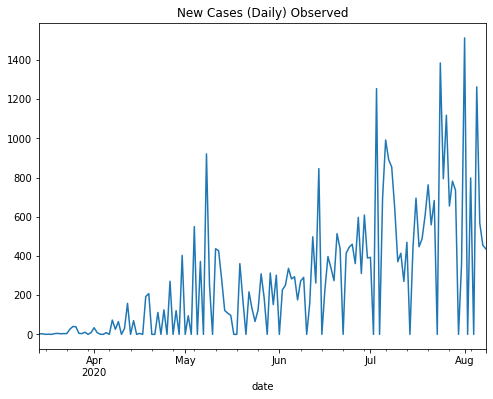

In [ ]:
new_cases_obs.plot(figsize=(8,6))
plt.title('New Cases (Daily) Observed')
plt.savefig(fname='/content/visuals/newCases_daily.png', format='png')

# Preprocessing and Modelling 
> Task d - f
- Split the data into one part used for inference (training set), and an other used for to validate a forecast (validation set):
- - Training set includes all dates from the time the community transmission reaches 100 to July 25 2020.
- - Validation set includes dates from 25 July 2020 to one final date in the covid19 cases data.  
- Plot the training data together with the model that is sampled from the posterior of the SIR model. The posterior of the SIR model means distributions on the Lambda, Mu, and other parameters. A single model curve means a single sample from the posterior distribution.
- Use the validation data set to evaluate the forecasting power of the model you generated using the training set. If you are happy with your model, you can run it to make predictions until the 10th of August.


In [ ]:
train_set = new_cases_obs[new_cases_obs.index <= '2020-07-25']
val_set = total_cases_obs[total_cases_obs.index >= '2020-07-25']
#new_cases_obs = new_cases_obs[new_cases_obs.index <= '2020-07-25']

In [ ]:
# #cummulative record
# ghana_cumm_record = jhu.get_total_confirmed_deaths_recovered(country='Ghana', begin_date= bd, end_date=ed)
print("Date Has empty row: ",f'{train_set.index.isnull().any()}')
train_set

Date Has empty row:  False


date
2020-03-14       3
2020-03-15       3
2020-03-16       0
2020-03-17       1
2020-03-18       0
              ... 
2020-07-21     559
2020-07-22     683
2020-07-23       0
2020-07-24    1385
2020-07-25     794
Name: confirmed, Length: 134, dtype: int64

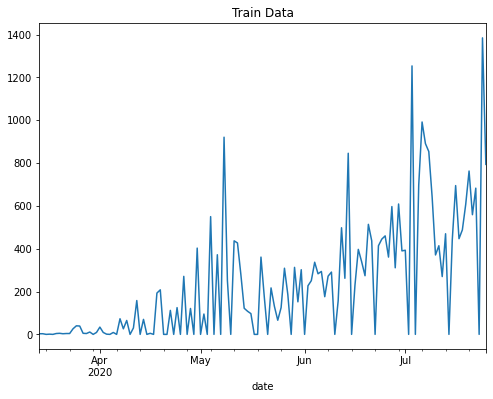

In [ ]:
train_set.plot(figsize=(8,6))
plt.title('Train Data')
plt.savefig(fname='/content/visuals/train_data_daily.png', format='png')

In [ ]:
print("Date Has empty row: ",f'{val_set.index.isnull().any()}')
val_set

Date Has empty row:  False


date
2020-07-25    31851
2020-07-26    32969
2020-07-27    33624
2020-07-28    34406
2020-07-29    35142
2020-07-30    35142
2020-07-31    35501
2020-08-01    37014
2020-08-02    37014
2020-08-03    37812
2020-08-04    37812
2020-08-05    39075
2020-08-06    39642
2020-08-07    40097
2020-08-08    40533
Name: confirmed, dtype: int64

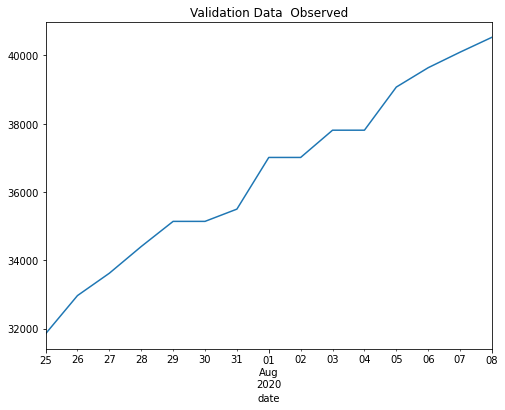

In [ ]:
val_set.plot(figsize=(8,6))
plt.title('Validation Data  Observed')
plt.savefig(fname='/content/visuals/val_data_cumm.png', format='png')

### Model training and Plotting (before identifying changepoints from the model output)

> Prior parameters and Prior Changepoints

- pr_delay = 3

- population = 31072940

- Changepoints 

 `I will start with  just one changepoint here -date when government initiated a partial lockdown policy` 

 `Subsequent models would be built on more than one changepoint`  

March 30th

> I used this date as prior becuase I believe there should be significant changepoint arounf this policy date. But I will test my prior with the posteriors of my model.


<!-- > I will compare my model output with validation set to see if there was significant change in the number of cases when the partial lockdown was introduced  -->
<!-- 
`I used these dates as prior becuase I believe there should be significant changepoints arounf these policy dates. But I will test my priors with the posteriors of my model. Note these dates are two days ahead the original dates to accomodate for the delay in effects of changepoints`  -->

<!-- > 1. 2020, 3, 30 - partial lockdown
2. 2020, 06,  15- ban on major gatherings
3. 2020, 07, 26 - restriction on travel -->

1. diff_data_sim - simulation of data should start ten days earlier before the start date of data

2. num_days_forcast - number of days to forecast after the end date of data

In [ ]:
diff_data_sim = 10  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

In [ ]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 30)
#prior_date_strong_dist_begin = datetime.datetime(2020, 6, 15)
#prior_date_contact_ban_begin = datetime.datetime(2020, 7, 26)

> model 1 changepoint


In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1
    )
    # ),
    # dict(
    #     pr_mean_date_transient=prior_date_strong_dist_begin,
    #     pr_sigma_date_transient=1.5,
    #     pr_median_lambda=1 / 8,
    #     pr_sigma_lambda=1,
    # ),
    # dict(
    #     pr_mean_date_transient=prior_date_contact_ban_begin,
    #     pr_sigma_date_transient=1.5,
    #     pr_median_lambda=1 / 8 / 2,
    #     pr_sigma_lambda=1,
    # ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [ ]:
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=31072940,
    name='Model1_SER',
)
# Median of the prior for the delay in case reporting, we assume 3 days
pr_delay = 3



The model is specified in a context. Each function in this context
has access to the model parameters set.


INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation



## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [ ]:
model1 =  pm.sample(model=this_model, cores=4, tune=50, draws=100, init="advi+adapt_diag")

Save Model

In [ ]:
#save model1
save_load_modelTrace("wb", model1, modelTrace_name="model1.pickle")
#load model1
model1=save_load_modelTrace("rb", model1, modelTrace_name="model1.pickle")

### Plot Timeseries for model1 (one changepoint) and compare performance with validation set


## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions



### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, model1, save_to="timeseries_model1.png",
                                     offset=3000) # start=datetime.datetime(2020,3,30), end=datetime.datetime(2020,8,21), 

### Validate model
> The model predicts an exponential growth in confrimed cases till August 2nd, 

> We can confirm this with our validation set...

> From the plot of our validation set below, there is an upward trend of confirmed cases in AUgust 2. which means our model predicts quite well. 

> But it can be further improved. We would increase the number of draws and tunes to imrpove the model power and extend it to predict up till August 10



In [ ]:
val_set.plot(figsize=(10,12));

> Plot a new model with higher tunes and draws

In [ ]:
diff_data_sim = 10  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 20

In [ ]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 30)
prior_date_strong_dist_begin = datetime.datetime(2020, 6, 15)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 26)

In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

In [ ]:
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=bd,
    data_end=ed,
    sim_begin=datetime.datetime(2020,3,4)
    sim_end=datetime.datetime(2020,8,4)
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=31072940,
    name='Model2_SER',


)
# Median of the prior for the delay in case reporting, we assume 3 days
pr_delay = 3

In [ ]:


model2 =  pm.sample(model=this_model, cores=4, tune=150, draws=200, init="advi+adapt_diag")